# Learning Canonical Transformations from Trajectories of an Integrable Model

## Neumann Hamiltonian

We consider the integrable Hamiltonian

$$
H = \frac{1}{4}\sum_{\alpha,\beta} J_{\alpha\beta}^2 + \frac{1}{2}\sum_\alpha k_\alpha x_\alpha^2
$$

with $J_\alpha\beta = x_\alpha p_\beta - x_\beta p_\alpha$ is the (generalized) angular momentum. The constants of motion are

$$
I_\alpha = x_\alpha^2 + \sum_{\beta\neq \alpha} \frac{J_{\alpha\beta}^2}{k_\alpha-k_\beta}
$$

for $k_\alpha$ all different. We have

$$
H = \frac{1}{2}\sum_\alpha k_\alpha I_\alpha
$$

And

$$
\sum_\alpha x_\alpha^2 = \sum_\alpha I_\alpha,
$$

so that motion is confined to the sphere $S^{N-1}$.

## Equations of Motion

The equations of motion have Hamiltonian form

$$
\begin{align}
\dot p_\alpha &= \frac{\partial H}{\partial x_\alpha} = -k_\alpha x_\alpha-\sum_\beta \left[x_\alpha p_\beta-x_\beta p_\alpha\right]p_\beta\\
\dot x_\alpha &= -\frac{\partial H}{\partial p_\alpha} = \sum_\beta \left[p_\alpha x_\beta-p_\beta x_\alpha\right]x_\beta
\end{align}
$$

In [1]:
import sys
sys.path.append("../")
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
from hamiltonians import parameterized_neumann
from models import SymplecticAdditiveCoupling, SymplecticExchange, Chain, MLP, IrrotationalMLP, LinearSymplecticTwoByTwo
from utils import visualize_chain_bijector_1d, extract_q_p, is_symplectic, run_eagerly
from data import BaseDistributionNormal

In [4]:
# tf.enable_eager_execution()
sess = tf.InteractiveSession()
tf.set_random_seed(0)

## Sample solution in TF

In [5]:
N = 3

In [6]:
ks = [0.1 , 0.2, 0.3] # Just to fix some values
ks_tensor = tf.constant(ks, dtype=tf.float32, name="ks")

In [13]:
def neumann_system(ks):
    def neumann_equations(phase_space_point, t):
        xs, ps = phase_space_point[::2], phase_space_point[1::2]
        dps = - ks * xs
        dps += -xs * tf.reduce_sum(ps**2)
        dps += ps * tf.reduce_sum(xs * ps)
        dxs = ps * tf.reduce_sum(xs**2)
        dxs += - xs * tf.reduce_sum(xs * ps)
        # join
        dxs = tf.expand_dims(dxs, axis=1)
        dps = tf.expand_dims(dps, axis=1)
        return tf.reshape(tf.concat([dxs,dps], axis=1), [-1])
    return neumann_equations

In [36]:
def neumann_batch(ks, size):
    N = ks.shape.as_list()[0]
    init_state = tf.random_uniform([2*N])
    t = tf.linspace(0.0, 100.0, num=size)
    tensor_state, tensor_info = tf.contrib.integrate.odeint(neumann_system(ks), init_state, t, full_output=True)
    return tensor_state

In [37]:
state = sess.run(neumann_batch(ks_tensor, 1000))
x, px, y, py, z, pz = state.T

Text(0, 0.5, 'momentum (p)')

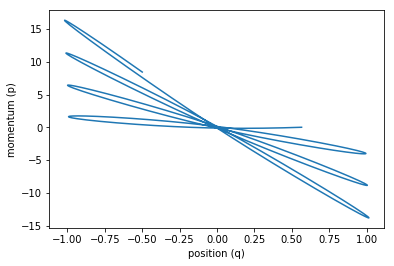

In [38]:
# plt.axes().set_aspect('equal', 'datalim')
plt.plot(x, px)
#plt.xlim(-2, 2)
#plt.ylim(-2, 2)
#plt.gca().set_aspect('equal')
plt.xlabel('position (q)')
plt.ylabel('momentum (p)')

## Check the integrals of motion

In [24]:
def Is(phase_space_point):
    xs, ps = phase_space_point[::2], phase_space_point[1::2]
    Is = xs**2 
    for α, _ in enumerate(Is):
        for β, _ in enumerate(Is):
            J = xs[α]*ps[β] - ps[α]*xs[β]
            if β != α:
                Is[α] += J**2 / (ks[α] - ks[β])
    return Is

In [25]:
I_traj = np.array([Is(point) for point in state])

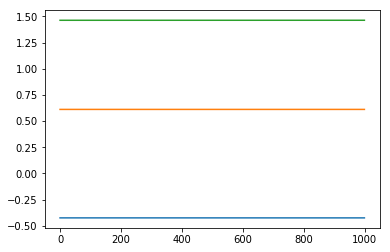

In [26]:
plt.plot(I_traj)

Check the implementation of the Neumann Hamiltonian yields correct value

In [27]:
neumann_hamiltonian = parameterized_neumann(ks_tensor)

In [28]:
init_state = tf.random_uniform([2*N])
sess.run(neumann_hamiltonian(tf.reshape(init_state, (1,-1,1,2))))

0.7794132

In [29]:
np.sum(ks*Is(sess.run(init_state))) / 2

0.17615047097206113

## Form Transformation by Chaining Bijectors

The idea is to map _from_ trajectories _to_ the phase plane of action angle variables, imposing the condition that the distribution factorizes.

In [30]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [31]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': parameterized_neumann(ks),  
    'd': N,               # space dimension
    'num_particles': 1,   # number of particles
    'batch_size': 256,   # Mini batch size 
    'stack_size': 2}      # Size of the stack of bijectors

Here we try modeling with:

1. `IrrotationalMLP`, which directly generates an irrotational vector field, without using autodifferentiation.

2. `LinearSymplecticTwoByTwo`, which learns linear symplectic transformations on each conjugate pair. 

There is freedom to choose different activations here. Could use traditional NN nonlinearities or simpler things like `tf.square`.

I guess we don't really need squeeze, as the linear transformation includes this.

In [32]:
with tf.name_scope("transform"):
    bijectors = []
    for _ in range(settings['stack_size']):
        bijectors.extend([SymplecticAdditiveCoupling(shift_model=IrrotationalMLP(activation=tf.nn.softplus)),
                          LinearSymplecticTwoByTwo()])
    model = Chain(bijectors)

## Form the Loss

The temperatures of the GGE distributions must be learned, but we must ensure they are positive

In [33]:
sqrt_betas = tf.get_variable("betas", shape=[1,N,1,1], dtype=DTYPE)
sqrt_betas_doubled = tf.tile(sqrt_betas, [1,1,1,2]) # shape = (1,N,1,2)

Accounting for the normalization, the log probability is

$$
\log p = -\sum_j \left[\beta_j \left(q_j^2+p_j^2\right)-\log (\beta_j/\pi)\right]
$$

__I've messed this up many times in implementation, so it's probably worth checking__ Seemed OK, rewritten a litte

In [34]:
# with tf.variable_scope("loss"):
#     base_dist = BaseDistributionNormal(settings)
#     z_samples = base_dist.sample(settings['batch_size'])    # shape = (batch,N,1,2)
#     loss = tf.reduce_mean( tf.square(z_samples) * sqrt_betas_doubled - tf.log(sqrt_betas_doubled) )

An alternative loss would be to ask that the (squared) radius of each variable doesn't fluctuate, so the loss is just the sum of the variances of the squared radii. The idea is to force the radial variables to be conserved.

In [35]:
with tf.name_scope("loss"):
    base_dist = BaseDistributionNormal(settings)
    z_samples = base_dist.sample(settings['batch_size'])
    loss = tf.reduce_mean(tf.square(model(z_samples)))
    
## TODO: update following commented lines
#     q, p = extract_q_p(model(z_samples))
#     z_doubled = tf.concat([q, p], 2)
#     square_radii = tf.reduce_sum(tf.square(z_doubled), axis=2)
#     var_square_radii = tf.reduce_mean(tf.square(square_radii), axis=0) - tf.square(tf.reduce_mean(square_radii, axis=0))
#     loss = tf.reduce_mean(var_square_radii)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


## Train

In [36]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step=step)

Add some summaries for tracking with TensorBoard

In [37]:
tf.summary.scalar("loss_function", tf.reshape(loss, []))
# tf.summary.scalar("mean_beta", tf.reshape(tf.reduce_mean(sqrt_betas**2), []))

<tf.Tensor 'loss_function:0' shape=() dtype=string>

Monitor training with `tensorboard --logdir logging/neumann`

In [38]:
tf.contrib.training.train(train_op, logdir="../logging/neumann/", save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../logging/neumann/model.ckpt.
INFO:tensorflow:global_step/sec: 171.555
INFO:tensorflow:global_step/sec: 287.748
INFO:tensorflow:global_step/sec: 276.601
INFO:tensorflow:global_step/sec: 270.492
INFO:tensorflow:global_step/sec: 385.899
INFO:tensorflow:global_step/sec: 469.503
INFO:tensorflow:global_step/sec: 431.85
INFO:tensorflow:global_step/sec: 452.945
INFO:tensorflow:global_step/sec: 516.895
INFO:tensorflow:global_step/sec: 517.882
INFO:tensorflow:global_step/sec: 487.448
INFO:tensorflow:global_step/sec: 363.11
INFO:tensorflow:global_step/sec: 351.602
INFO:tensorflow:global_step/sec: 336.118
INFO:tensorflow:global_step/sec: 357.335
INFO:tensorflow:global_step/sec: 389.852
INFO:tensorflow:global_step/sec: 359.195
INFO:tensorflow:global_step/sec: 333.399
INFO:tensorflow:global_

KeyboardInterrupt: 

## Look at the Learned Representation

Load the saved model. If not training, first evaluate all cells _except_ for those in the __Train__ section. 

In [39]:
traindir = "../logging/neumann/"
saver = tf.train.Saver()

In [40]:
ckpt_state = tf.train.get_checkpoint_state(traindir)
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ../logging/neumann/model.ckpt-0


How do the trajectories look in the phase planes of the new variables? 

In [41]:
traj = sess.run(z_samples)
q1, p1, q2, p2, q3, p3 = np.reshape( traj, (-1,6) ).T

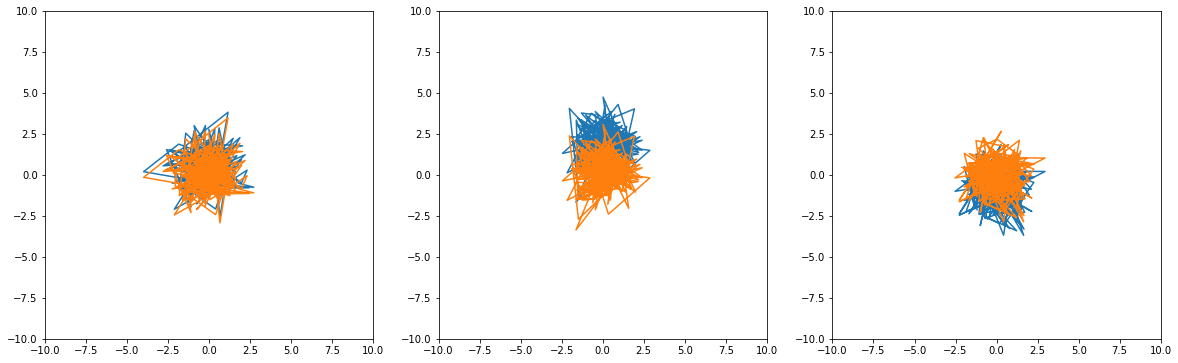

In [42]:
transformed_traj = sess.run(model(tf.constant(traj)))
x1, y1, x2, y2, x3, y3 = np.reshape( transformed_traj, (-1,6) ).T

plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.plot(x1, y1)
plt.plot(q1, p1)
# plt.axis('equal')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1, 3, 2)
plt.plot(x2, y2)
plt.plot(q2, p2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1, 3, 3)
plt.plot(x3, y3)
plt.plot(q3, p3)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')
